In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(1234)

# Model 2
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn.metrics import mean_squared_error as MSE

# Model 2: Autoencoder

Build autoencoder using z-scaled PCs from previous model

In [32]:
enc = pc_to_keep_z.drop('SUM', axis=1)

In [33]:
enc

,PC1,PC2,PC3,PC4
0,0.000939,-0.090230,-0.081992,-0.063785
1,4.199913,16.128732,5.241872,1.222970
2,0.006287,0.064573,-0.043461,0.010342
3,0.044381,-0.074404,-0.043499,-0.079560
4,9.410793,-4.801232,2.740579,-12.562188
...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526
1070990,-0.035513,-0.078378,-0.031540,-0.002969
1070991,-0.030828,-0.080535,-0.027994,0.000618
1070992,-0.021493,-0.065886,-0.013105,-0.014869


In [34]:
inp = Input(shape=(enc.shape[1], ))
encode = Dense(20, input_shape=(enc.shape, ), activation='relu')(inp)
encode = Dense(10, activation='relu')(encode)
decode = Dense(20, activation='relu')(encode)
decode = Dense(enc.shape[1], activation='relu')(decode)
model = Model(inputs=inp, outputs=decode)

In [35]:
callbacks = [EarlyStopping(patience=5, monitor='mean_squared_error', verbose=1),
             ModelCheckpoint('alex_best_model.h5', monitor='mean_squared_error', save_best_only=True, verbose=1)]

In [37]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

history = model.fit(enc, enc,
                    epochs=25,
                    callbacks=callbacks)

Epoch 1/25
33469/33469 [==============================] - 28s 815us/step - loss: 0.3303 - mean_squared_error: 0.3303

Epoch 00001: mean_squared_error improved from inf to 0.46962, saving model to alex_best_model.h5
Epoch 2/25
33469/33469 [==============================] - 30s 906us/step - loss: 0.9448 - mean_squared_error: 0.9448

Epoch 00002: mean_squared_error did not improve from 0.46962
Epoch 3/25
33469/33469 [==============================] - 37s 1ms/step - loss: 0.5936 - mean_squared_error: 0.5936

Epoch 00003: mean_squared_error improved from 0.46962 to 0.44045, saving model to alex_best_model.h5
Epoch 4/25
33469/33469 [==============================] - 35s 1ms/step - loss: 0.5453 - mean_squared_error: 0.5453

Epoch 00004: mean_squared_error did not improve from 0.44045
Epoch 5/25
33469/33469 [==============================] - 32s 965us/step - loss: 0.5509 - mean_squared_error: 0.5509

Epoch 00005: mean_squared_error did not improve from 0.44045
Epoch 6/25
33469/33469 [=========

In [38]:
model.load_weights('alex_best_model.h5')

In [39]:
preds = model.predict(enc)
enc_array = np.array(enc)

In [40]:
def rep_error(z, z_):
    return (np.sum((np.abs(np.subtract(z, z_))**2)))**(1/2)

error_lambda = lambda x, y: rep_error(x, y)

In [41]:
rep_error = list(map(error_lambda, enc_array, preds))

In [63]:
enc['model2_score'] = rep_error

In [64]:
enc

,PC1,PC2,PC3,PC4,REP_ERROR,model2_score
0,0.000939,-0.090230,-0.081992,-0.063785,0.138217,0.138217
1,4.199913,16.128732,5.241872,1.222970,5.661178,5.661178
2,0.006287,0.064573,-0.043461,0.010342,0.047679,0.047679
3,0.044381,-0.074404,-0.043499,-0.079560,0.117366,0.117366
4,9.410793,-4.801232,2.740579,-12.562188,13.739668,13.739668
...,...,...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526,0.078142,0.078142
1070990,-0.035513,-0.078378,-0.031540,-0.002969,0.091695,0.091695
1070991,-0.030828,-0.080535,-0.027994,0.000618,0.090666,0.090666
1070992,-0.021493,-0.065886,-0.013105,-0.014869,0.072081,0.072081


<AxesSubplot:xlabel='model2_score', ylabel='Density'>

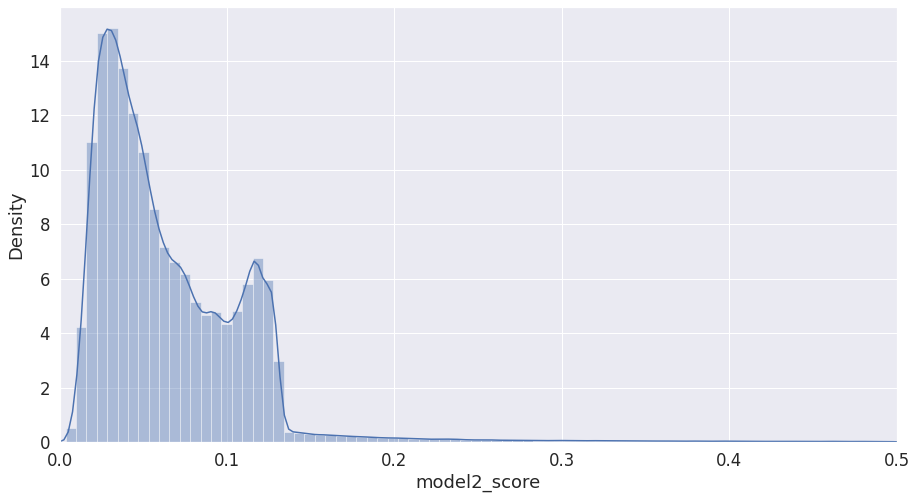

In [65]:
plt.rcParams["figure.figsize"] = [15,8]
sns.set(font_scale=1.5)
xhigh = 0.5
plt.xlim(0,xhigh)
temp = enc[(enc['model2_score'] <= xhigh)]
sns.distplot(temp.model2_score, bins = 80, kde=True)